# Kunskapskontroll 1

## Utförd av Isabelle Trysberg, Anna Brunskog och Cyritha Ljungberg



### Importering av användbara bibliotek, inläsning av data samt EDA-analys

In [32]:
# Databearbetning/preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# Visualisering
import matplotlib.pyplot as plt
import seaborn as sns


# Datauppdelning
from sklearn.model_selection import train_test_split


# ML-modeller
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge


# Modellutvärdering och validering
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score   #returnerar mått (t ex RMSE) för jämförelser. Ungefär samma som cross_validate (som visar fler mått och tider samtidigt)
from sklearn.pipeline import Pipeline


# Importerar verktyg för att kunna behandla olika kolumner på olika sätt
from sklearn.compose import ColumnTransformer # för att hantera all omvandling i samma process
from sklearn.preprocessing import OneHotEncoder, StandardScaler # för att göra text->siffror och skala om numeriska kolumner
from sklearn.pipeline import Pipeline # för att kunna köra flera steg i följd
from sklearn.impute import SimpleImputer # för hantering av null-värden

from sklearn.linear_model import Ridge

Inläsning av lämpliga bibliotek är klar. Vi har valt att samla alla bibliotek i början.
Nästa steg är indelning och överblick av data.

In [2]:
# Laddar in datasetet från Github
# Justerar separator till ;

df_raw = pd.read_csv("car_price_dataset.csv", sep=";")   # Original
df = df_raw.copy()

df_raw = pd.read_csv("car_price_dataset.csv", sep=";")    #original
df = df_raw.copy()    # arbetskopia 



df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [3]:
df.isnull().sum()


Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [5]:
df.describe()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


Efter att ha analyserat datatyper och förekomst av nullvärden kan vi konstatera att datasetet inte innehåller några tomma värden.

Datasetet består av numeriska och kategoriska variabler och omfattar data relaterat till 10 000 bilar. 

Vi går vidare och delar in data i X och y.



In [6]:
# Features (alla kolumner utom Price)
X = df.drop(columns=["Price"])

# Target (som vi vill prediktera)
y = df["Price"]

# Snabb kontroll så att det stämmer
X.shape, y.shape


((10000, 9), (10000,))

Vi går vidare med att dela in data i träningsdata och testdata.

In [7]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42  #lätt att återskapa med samma random_state
)

X_train.shape, X_test.shape

((8000, 9), (2000, 9))

Datan har delats upp i träningsdata på 80 % och testdata på 20 %.
Träningsdatan tränar modellen medan testdatan utvärderar prestandan på tidigare osedd data vi stoppar därför undan testdatan tills vi har valt modell och skall testköra.


In [10]:
# Skapar en ny dataframe som endast innehåller vår träningsdata för EDA
df_train = X_train.copy()
df_train["Price"] = y_train

Gör EDA på träningsdata och undersöker korrelation i datan

In [11]:
corr_matrix = df_train.corr(numeric_only=True)
corr_matrix["Price"].sort_values(ascending=False)

Price          1.000000
Year           0.663176
Engine_Size    0.362010
Doors          0.004508
Owner_Count   -0.000079
Mileage       -0.551387
Name: Price, dtype: float64

Ovan korrelationsanalys säger oss att Price är mest korrelaterat till Year, Milage och Engine_Size

<Axes: title={'center': 'Antal per bilmärke'}, xlabel='Märke', ylabel='Antal'>

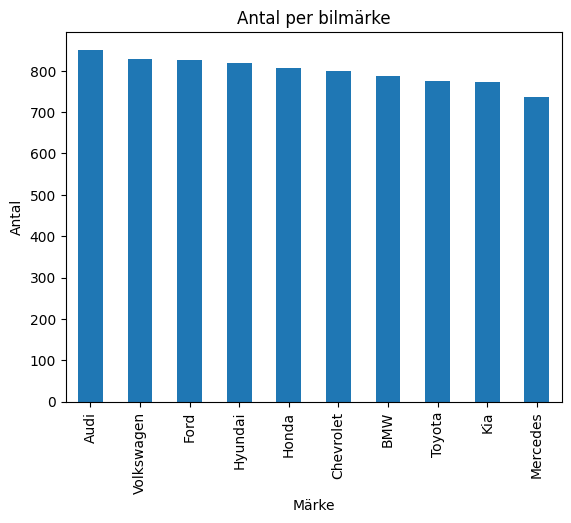

In [12]:
# Vi får fram ett stapeldiagram med antal bilar per märke och ser hur dessa fördelar sig.

df_train["Brand"].value_counts().plot(
    kind="bar",
    title="Antal per bilmärke",
    xlabel="Märke",
    ylabel="Antal"
)

Fortsätter EDA för att undersöka pris vs årsmodell

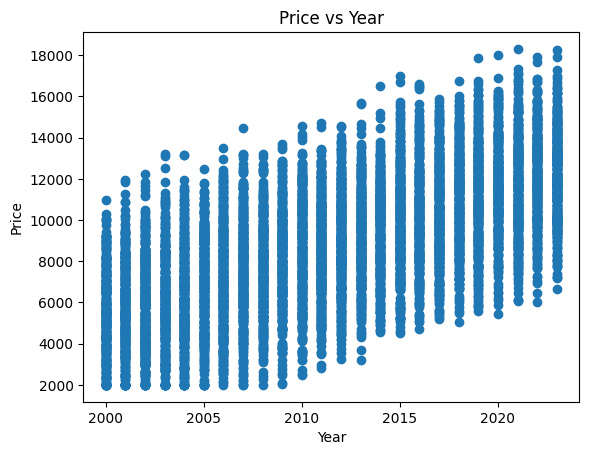

In [13]:
# Pris vs År
plt.scatter(X_train["Year"], y_train)
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Price vs Year")
plt.show()

In [14]:
# Antal unika värden per kolumn i datasetet, kardinalitet.

df_train.nunique()

Brand             10
Model             30
Year              24
Engine_Size       41
Fuel_Type          4
Transmission       3
Mileage         7907
Doors              4
Owner_Count        5
Price           5748
dtype: int64

<Axes: ylabel='Model'>

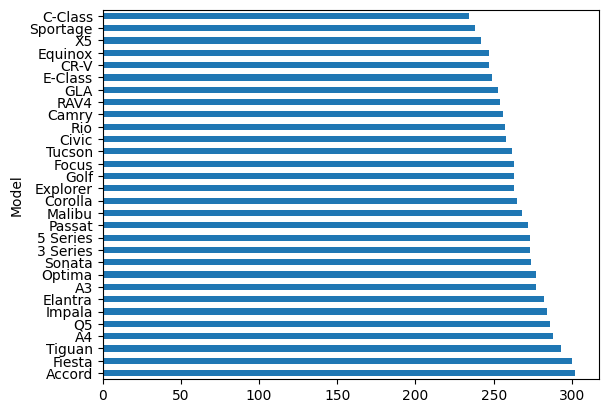

In [15]:
# Skapar ett stapeldiagram som visar frekvensfördelning för varje bilmodell

df_train["Model"].value_counts().plot(kind="barh")

<Axes: title={'center': 'Antal per bränsletyp'}, xlabel='Bränsletyp', ylabel='Antal'>

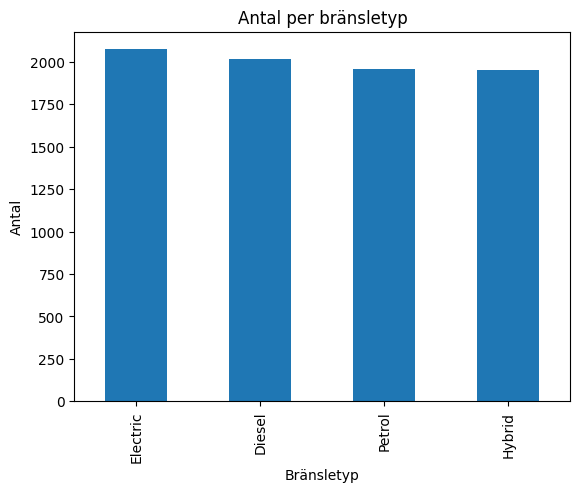

In [16]:
# Stapeldiagram över fördelningan av bilar per bränsletyp

df_train["Fuel_Type"].value_counts().plot(
    kind="bar",
    title="Antal per bränsletyp",
    xlabel="Bränsletyp",
    ylabel="Antal"
)

<Axes: title={'center': 'Typ av växellåda'}, xlabel='Växellåda', ylabel='Antal'>

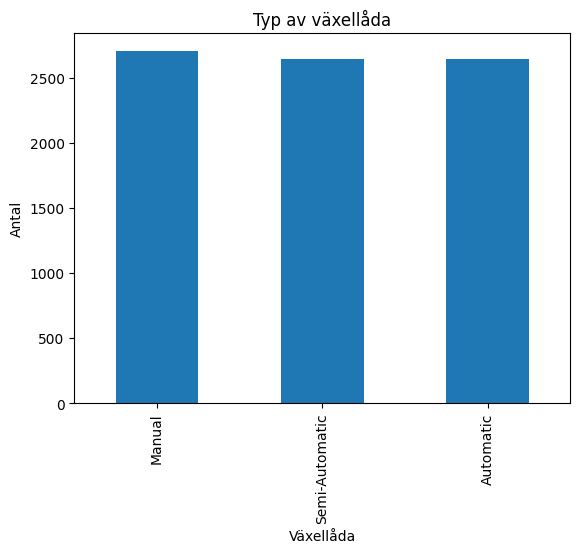

In [17]:
# Fördelning av bilar per växellåda

df_train["Transmission"].value_counts().plot(
    kind="bar",
    title="Typ av växellåda",
    xlabel="Växellåda",
    ylabel="Antal"
)

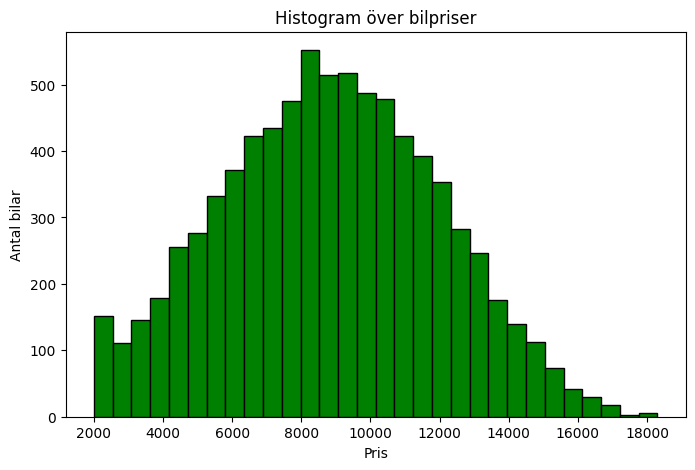

In [18]:
# Skapar ett histogram på visar priser för att se fördelningen och antyda eventuella outliers eller ojämnheter i datasetet

plt.figure(figsize=(8,5))
plt.hist(df_train['Price'], bins=30, color='green', edgecolor='black')
plt.title("Histogram över bilpriser")
plt.xlabel("Pris")
plt.ylabel("Antal bilar")
plt.show()

Vi identifierar outliers och planen är att eventuellt prova att ta bort dessa för att kunna jämföra hur mycket de påverkar ML-modellerna.

In [20]:
# Kontrollerar antal outliers i Price samt visar dessa i procent
# IQR-metoden är en robust modell mot snedfördelad data, delas upp efter kvartiler

Q1 = df_train["Price"].quantile(0.25)
Q3 = df_train["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR  # Nedre gräns för outliers
upper_bound = Q3 + 1.5 * IQR  # Övre gräns för outliers

outliers_price = df_train[
    (df_train["Price"] < lower_bound) | (df_train["Price"] > upper_bound)
]

print("Antal outliers i Price:", len(outliers_price))


print("Andel outliers (%):", len(outliers_price) / len(df_train) * 100)

Antal outliers i Price: 6
Andel outliers (%): 0.075


In [21]:
# Kontrollerar antal outliers i Mileage på samma sätt

Q1 = df_train["Mileage"].quantile(0.25)
Q3 = df_train["Mileage"].quantile(0.75)
IQR = Q3 - Q1

lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR

outliers_mileage = df_train[(df_train["Mileage"] < lb) | (df_train["Mileage"] > ub)]
print("Antal outliers i Mileage:", len(outliers_mileage))

Antal outliers i Mileage: 0


Vi kan se att det finns enstaka outliers vad gäller de högsta priserna. Detta tar vi hänsyn till i kommande analyser. Inom Mileage kan vi inte identifiera några outliers. 
Nu är vi nöjda med EDA.

I och med att ML-modeller inte kan hantera text så skapar vi ett flöde som omvandlar text till siffror, och skalar om numeriska värden.

In [22]:
# Skapar en lista med alla kolumner som är kategoriska (text) och måste kodas om till siffror
categorical_cols = ["Brand", "Model", "Fuel_Type", "Transmission"]

# Skapar en lista med alla kolumner som är numeriska och som ska skalas om
numeric_cols = ["Year", "Mileage", "Engine_Size", "Doors", "Owner_Count"]


# Pipeline för kategoriska kolumner:
# - fyller NaN med vanligaste värdet
# - kodar om text till dummyvariabler
cat_pipeline = Pipeline (steps= [
    ("imputer", SimpleImputer (strategy="most_frequent")),
    ("encoder", OneHotEncoder (sparse_output=False, handle_unknown="ignore", drop="first"))
]) 
# Pipeline för numeriska kolumner:
# - fyller NaN med median (robust mot outliers)
# - skalar värdena med StandardScaler
num_pipeline = Pipeline (steps= [
    ("imputer", SimpleImputer (strategy="median")),
    ("scaler", StandardScaler ())
])

# Skapar en process för att omvandla text till siffror, skalar siffror och låter ev övriga kolumner vara (remainder="passthrough")
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_cols),
        ("num", num_pipeline, numeric_cols)
    ],
    remainder="passthrough"
)

I EDA ser vi att det verkar vara ett linjärt samband och vi börjar därför med att testa en klassisk linjär modell. Vi använder crossvalidation för utvärdering av samtliga modeller.

In [24]:
# Korsvalidering körs ENDAST på träningsdata (X_train, y_train).
# Testdata (X_test, y_test) används inte här.

linreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

cv_scores = cross_val_score(
    linreg_pipe,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,             
    error_score="raise"     
)

# Gör om till positiva RMSE-värden
cv_rmse = -cv_scores

# RMSE - medelvärde och standardavvikelse
print(f"Linear Regression CV RMSE per fold: {cv_rmse}")        
print("Linear Regression CV RMSE (mean):", cv_rmse.mean())
print("Linear Regression CV RMSE (std):", cv_rmse.std())


Linear Regression CV RMSE per fold: [ 80.03681872 109.81572753 104.79446289  87.18833908  63.47819106]
Linear Regression CV RMSE (mean): 89.06270785763931
Linear Regression CV RMSE (std): 16.83878484249809


Modellen tränas 5 gånger, preprocessing körs alltid på rätt sätt innan träning och RMSE beräknas

Ovan gav ett väldigt bra RMSE-värde, och linjär modell verkar funka bra! Det är dock hög standardavvikelse vilket kan innebära att modellen är ostabil. Vi går vidare och testar en annan linjär variant, Lasso.

In [25]:
# Tränar modellen

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=1.0, max_iter=10000))
])


# Cross-validation med 5 folds
cv_scores = cross_val_score(
    model, 
    X_train,  # Använd bara träningsdata
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # sklearn använder negativa värden
)

# Räkna om till RMSE
cv_rmse = np.sqrt(-cv_scores)  # Negera tillbaka och ta kvadratroten

# Skriver ut både rmse per fold, medel och standardavvikelse för att se hur stabil modellen är
print(f"Cross-validation RMSE per fold: {cv_rmse}")
print(f"Medel RMSE Lasso: {cv_rmse.mean():.2f}")
print(f"Standardavvikelse: {cv_rmse.std():.2f}")

Cross-validation RMSE per fold: [ 80.14624066 109.60086922 104.39540096  87.26509679  64.23827229]
Medel RMSE Lasso: 89.13
Standardavvikelse: 16.47


Lasso-modellen fick snarlikt utfall som den vanliga linjära modellen. Vi går vidare med att justera hyperparametrar i Lasso för att se om vi kan trimma ner RMSE ytterligare med denna modell.

In [26]:
# Behåller samma setup som med ovan Lasso-modell.

model = Pipeline([
    ("preprocess", preprocessor),
    ("lasso", Lasso(max_iter=10000))
])

param_grid = {'lasso__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]} # Testar olika värden för alpha

grid_search = GridSearchCV(model, param_grid, cv=5,  # använder 5 folds för varje test
                           scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_rmse = np.sqrt(-grid_search.best_score_)
print(f"\nBästa alpha: {grid_search.best_params_['lasso__alpha']}") # skriver ut vilket värde på alpha som gav bäst score
print(f"Bästa CV RMSE: {best_rmse:.2f}") # skriver ut bästa RMSE med ovan alpha


results = pd.DataFrame(grid_search.cv_results_)
print("\nAlla alpha-resultat:")
for alpha, score in zip(results['param_lasso__alpha'], results['mean_test_score']):
    rmse = np.sqrt(-score)
    print(f"Alpha {alpha}: RMSE {rmse:.2f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Bästa alpha: 0.5
Bästa CV RMSE: 90.50

Alla alpha-resultat:
Alpha 0.1: RMSE 90.51
Alpha 0.5: RMSE 90.50
Alpha 1.0: RMSE 90.64
Alpha 2.0: RMSE 91.23
Alpha 5.0: RMSE 95.30


Då GridSearch gav bästa apha 0.5 går vi vidare med att köra Lasso-modellen igen, fast med ett uppdaterat alpha-värde.


In [27]:
# Tränar modellen

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=0.5, max_iter=10000)) # Uppdaterar alpha-värdet enligt ovan GridSearch
])

# Cross-validation med 5 folds
cv_scores = cross_val_score(
    model, 
    X_train,  # Använd bara träningsdata
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # sklearn använder negativa värden
)

# Räkna om till RMSE
cv_rmse = np.sqrt(-cv_scores)  # Negera tillbaka och ta kvadratroten

# Skriver ut både rmse per fold, medel och standardavvikelse för att se hur stabil modellen är
print(f"Cross-validation RMSE per fold: {cv_rmse}")
print(f"Medel RMSE Lasso: {cv_rmse.mean():.2f}")
print(f"Standardavvikelse: {cv_rmse.std():.2f}")

Cross-validation RMSE per fold: [ 79.95552363 109.59368234 104.4823561   87.05541299  63.66918625]
Medel RMSE Lasso: 88.95
Standardavvikelse: 16.68


Denna gången gav Lasso, med det nya alpha-värdet, ett bättre utfall än den vanliga linjära modellen. Vi arbetade enligt en iterativ process som visade att Lasso-modellen gav bäst resultat (se senare tester av andra modeller). För tydlighetens skull har vi placerat samtliga optimeringstest av Lasso-modellen i följd.

Vi ser att Lasso är den bästa modellen med samtliga variabler. Nästa steg är att testa vår teori om Brand verkligen tillför något, eller kan tas bort då vi ändå har Model. Vi kör vidare med Lasso, men denna gång utan Brand.

In [ ]:
# Uppdaterar våra kategoriska variabler där Brand är borttagen,
categorical_cols = ["Model", "Fuel_Type", "Transmission"]
numeric_cols = ["Year", "Mileage", "Engine_Size", "Doors", "Owner_Count"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_cols),
        ("num", num_pipeline, numeric_cols)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=0.5, max_iter=10000)) # Behåller det nya alpha-värdet enligt ovan GridSearch
])


# Cross-validation med 5 folds
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # sklearn använder negativa värden
)

# Räkna om till RMSE
cv_rmse = np.sqrt(-cv_scores)  # Negera tillbaka och ta kvadratroten

# Skriver ut både rmse per fold, medel och standardavvikelse för att se hur stabil modellen är
print(f"Cross-validation RMSE per fold: {cv_rmse}")
print(f"Medel RMSE Lasso: {cv_rmse.mean():.2f}")
print(f"Standardavvikelse: {cv_rmse.std():.2f}")

Cross-validation RMSE per fold: [ 79.91680739 109.60381104 104.47707364  87.05367397  63.67698133]
Medel RMSE Lasso: 88.95
Standardavvikelse: 16.68


Vi ser att Brand inte påverkade någonting, därför väljer vi att gå vidare utan Brand för att minska antal variabler och därför öka prestandan i modellen. Nästa steg är att kontrollera om outliers påverkar.

In [29]:
# Kod för outliers:
# Beräkna outliers/bounds på träningsdata
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hitta vilka rader som INTE är outliers
mask = (y_train >= lower_bound) & (y_train <= upper_bound)

# Filtrera både X och y med samma mask för att ta bort outliers i Y med tillhörande kolumner X
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

# Skriv ut antal outliers för att verifiera att det är samma antal som i EDA
print(f"Borttagna outliers: {(~mask).sum()}")

Borttagna outliers: 6


In [30]:
# Ny kod för uppdatera modell utan outliers: 

# Tränar om modellen med nya variabler utan outliers
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=0.5, max_iter=10000))
])

model.fit(X_train_clean, y_train_clean)


# Cross-validation av ny modell med 5 folds
cv_scores = cross_val_score(
    model, 
    X_train_clean,  
    y_train_clean, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error'  # sklearn använder negativa värden
)

# Räkna om till RMSE
cv_rmse = np.sqrt(-cv_scores)  # Negera tillbaka och ta kvadratroten

# Skriver ut både rmse per fold, medel och standardavvikelse för att se hur stabil modellen är
print(f"Cross-validation RMSE per fold utan outliers: {cv_rmse}")
print(f"Medel RMSE utan outliers: {cv_rmse.mean():.2f}")
print(f"Standardavvikelse utan outliers: {cv_rmse.std():.2f}")


Cross-validation RMSE per fold utan outliers: [ 79.94921347 109.62527141 104.49846483  87.04743672  63.72169921]
Medel RMSE utan outliers: 88.97
Standardavvikelse utan outliers: 16.68


Borttagning av outliers påverkade till det sämre, vi väljer därför att behålla dessa - men fortfarande ta bort Brand.

## Test av andra modeller
Ridge Regression är en regulariserad variant av linjär regression där en straffterm läggs till för att minska risken för överanpassning.
Den är ett bra nästa steg när man har många features.

In [31]:
#Samma preprocessor körs i Pipeline innan modellen körs
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge())
])


# Hitta den bästa alpha-parametern i Ridge-modellen
param_grid_ridge = {
    "model__alpha": [0.01, 0.1, 1, 10, 50, 100]
}

#
gs_ridge = GridSearchCV(
    ridge_pipe,
    param_grid=param_grid_ridge,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    error_score="raise"
)

# Tränar modellen
gs_ridge.fit(X_train, y_train)

# Skriver ut bästa parameterkombinationen och bästa RMSE-värdet
print("Ridge best params:", gs_ridge.best_params_)
print("Ridge CV RMSE:", -gs_ridge.best_score_)



# Loopar igenom resultaten från GridSearchCV # Skriver ut medelvärde av RMSE över CV-folds, standardavvikelse och tillhörande alpha-värde
for mean, std, alpha in zip(
    -gs_ridge.cv_results_["mean_test_score"],
    gs_ridge.cv_results_["std_test_score"],
    gs_ridge.cv_results_["param_model__alpha"]
):
    print(f"alpha={alpha}: RMSE={mean:.2f}, std={std:.2f}")  # Skriver ut medelvärde av RMSE över CV-folds, standardavvikelse och tillhörande alpha-värde



Ridge best params: {'model__alpha': 0.01}
Ridge CV RMSE: 89.06285409595145
alpha=0.01: RMSE=89.06, std=16.84
alpha=0.1: RMSE=89.06, std=16.83
alpha=1.0: RMSE=89.09, std=16.76
alpha=10.0: RMSE=90.60, std=15.79
alpha=50.0: RMSE=115.80, std=10.05
alpha=100.0: RMSE=162.88, std=5.48


## Decision tree och Random Forest
Nästa steg är att testa även Decision Tree och RandomForestRegressor (som kan fånga icke-linjära samband och är mindre känslig för outliers) för att se vilken metod som lämpar sig bäst för det aktuella datasetet



Beslutsträd:

Modellen utvärderades med korsvalidering på träningsdatan och visade en stabil men relativt begränsad prediktiv förmåga, vilket indikerar att ett enskilt träd har svårt att fånga mer komplexa samband i datan.


In [33]:

# ============================================================
# GRIDSEARCH: DECISION TREE
# ============================================================

tree_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),  
    ("model", DecisionTreeRegressor(random_state=42))
])

# Full parameter-grid 
tree_param_grid = {
    "model__max_depth": [None, 3, 5, 8, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10, 20, 50],
    "model__min_samples_leaf": [1, 2, 4, 8, 16],
    "model__max_features": [None, "sqrt", "log2"]
}

tree_grid = GridSearchCV(
    estimator=tree_pipe,
    param_grid=tree_param_grid,
    scoring="neg_root_mean_squared_error",  
    cv=5,
    n_jobs=-1,
    verbose=1
)

tree_grid.fit(X_train, y_train)

tree_best_rmse = -tree_grid.best_score_
print("\n=== Decision Tree ===")
print("Bästa parametrar:", tree_grid.best_params_)
print(f"Bästa CV RMSE: {tree_best_rmse:.2f}")


Fitting 5 folds for each of 525 candidates, totalling 2625 fits

=== Decision Tree ===
Bästa parametrar: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Bästa CV RMSE: 861.07


Random Forest:

För att förbättra resultaten testades även Random Forest, som bygger på en ensemble av flera beslutsträd. Modellen gav lägre RMSE och jämnare resultat mellan foldsen jämfört med beslutsträdet, vilket tyder på bättre generaliseringsförmåga. Nackdelen var längre beräkningstid, men prestandaförbättringen motiverade valet.

In [34]:
# ============================================================
# GRIDSEARCH: RANDOM FOREST
# ============================================================

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# rf_param_grid = {
    #  Skogens storlek (fler träd = stabilare men långsammare)
    # "model__n_estimators": [200, 400, 600],

    #  Trädens komplexitet
    # "model__max_depth": [None, 10, 20, 30],
    # "model__min_samples_split": [2, 5, 10],
    # "model__min_samples_leaf": [1, 2, 4],

    #  Hur många features som testas per split (påverkar bias/variance)
    # "model__max_features": ["sqrt", "log2", None],

    #  Bootstrap påverkar variationen mellan träden
    # "model__bootstrap": [True, False]
#}

# Ett komplicerat grid tar alldeles för lång tid så vi byter till ett betydligt enklare

rf_param_grid = {
    "model__n_estimators": [200, 300],
    "model__min_samples_split": [5, 10],
    "model__min_samples_leaf": [2, 5],
}

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

rf_best_rmse = -rf_grid.best_score_
print("\n=== Random Forest ===")
print("Bästa parametrar:", rf_grid.best_params_)
print(f"Bästa CV RMSE: {rf_best_rmse:.2f}")

# ============================================================
# SAMMANFATTNING 
# ============================================================

print("\n--- Jämförelse  ---")
print(f"Decision Tree: {tree_best_rmse:.2f}")
print(f"Random Forest: {rf_best_rmse:.2f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Random Forest ===
Bästa parametrar: {'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Bästa CV RMSE: 560.30

--- Jämförelse  ---
Decision Tree: 861.07
Random Forest: 560.30


Vid jämförelse med övriga modeller såg vi att Decision Tree och Random Forest presterat betydligt sämre än sina linjära motsvarigheter. Vi gick därför inte djupare i dessa modeller. Vinnaren är således Lasso-modellen. Nästa steg är att träna om vår modell med all träningsdata för att se hur den presterar mot vår testdata.

In [35]:
# Använder samma uppsättning som tidigare
categorical_cols = ["Model", "Fuel_Type", "Transmission"]
numeric_cols = ["Year", "Mileage", "Engine_Size", "Doors", "Owner_Count"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_cols),
        ("num", num_pipeline, numeric_cols)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=0.5, max_iter=10000)) 
])

# Tränar om modellen utan Brand men inkl outliers.
model.fit(X_train, y_train)

# Predikterar på testdatan som varit helt orörd.
y_test_pred = model.predict(X_test)

# Beräknar RMSE.
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Lasso Testdata RMSE: {test_rmse:.2f}")

Lasso Testdata RMSE: 64.77


Sammanfattningsvis kan vi konstatera att de linjära modellerna är fungerar klart bäst. Av de linjära modellerna är det Lasso som ger bäst resultat, även om skillnaden mot den linjära modellen är försumbar. Trädmodeller ligger väldigt långt ifrån och med det kan vi konstatera att datan i sig är väldigt linjär. Vi kan också konstatera att det är pris, miltal och motorstorlek som påverkar utfallet medan övriga variabler, som har ytterst liten påverkan. Även outliers påverkar marginellt. 
Utfallet på en RMSE på 64.77 av ett medelvärde på pris på c:a 8900 är en avvikelse på under 1%, vilket vi bedömer som orealistiskt i ett verkligt case.
Det har varit väldigt intressant att jämföra modeller i grupparbetsform, men vi haft stora utmaningar med Git-Hub, vilket har gjort processen långsammare än nödvändigt. Ytterligare steg hade kunna vara att fördjupa sig i variabelselektion för att se om man kunde öka prestandan.